In [364]:
#!pip install --upgrade pip

In [365]:
#!pip install control

#pip install plotly
#pip install nbformat
#pip install SciencePlots 
#!pip install latex


In [1]:
# --- Importando Bibliotecas Fundamentais ---
import numpy as np  # Para computação numérica, especialmente operações com arrays e matrizes.
import matplotlib.pyplot as plt  # Para criar gráficos e visualizações de dados 2D e 3D.
import sympy as sym  # Para matemática simbólica (manipulação de equações, derivadas, etc.).
from scipy.integrate import odeint  # Para resolver numericamente Equações Diferenciais Ordinárias (EDOs).

# --- Módulos para Animação ---
from matplotlib import animation  # Módulo principal para criar animações a partir de gráficos.
from mpl_toolkits.mplot3d import Axes3D  # Kit de ferramentas para plotagem de gráficos em 3D.
from matplotlib.animation import PillowWriter  # Para salvar as animações criadas como arquivos .gif.

# --- Bibliotecas de Engenharia de Controle ---
import control as ct  # Biblioteca para análise e simulação de sistemas de controle.
import slycot as slc  # Dependência do 'control' para rotinas numéricas mais avançadas.

# --- Módulos de Estilo e Formatação ---
import scienceplots  # Para aplicar estilos de formatação científica aos gráficos.
import latex         # Para renderizar texto e equações usando LaTeX nos gráficos.
plt.style.use(['science'])  # Ativa o estilo de gráfico 'science' para todas as plotagens subsequentes.

# 1 Modelagem Simbólica pelo módulo Sympy

In [2]:
# --- Definindo as variáveis simbólicas ---

# O objetivo aqui é criar representações matemáticas (símbolos) em vez de valores numéricos,
# para que se possa manipular equações algebricamente.

# --- Constantes ---
# Cria símbolos para as constantes físicas do sistema (massa, comprimento, gravidade, etc.).
# Cada letra se torna um símbolo matemático que pode ser usado em equações.
M, m1, m2, l1, l2, J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 l1 l2 J1 J2 g t f0 f1 f2')

# --- Variáveis ---
# Define as variáveis de estado e de entrada como funções simbólicas do tempo 't'.
# 'cls=sym.Function' informa ao sympy que phi1(t), x(t), etc., não são apenas símbolos,
# mas funções, o que permite calcular derivadas em relação ao tempo (d(phi1(t))/dt).
phi1, phi2, x, u, theta1, theta2 = sym.symbols(r'phi1 phi2 x u theta1 theta2', cls=sym.Function)

In [3]:
# --- Definindo as derivadas no tempo ---

x = x(t)        # Posição x do carro como uma função explícita de t, x(t).
u = u(t)        # Variável de controle (força) como uma função explícita de t, u(t).
phi1 = phi1(t)    # Ângulo do pêndulo inferior como uma função explícita de t, phi1(t).
phi2 = phi2(t)    # Ângulo do pêndulo superior como uma função explícita de t, phi2(t).
theta1 = theta1(t) # Ângulo do pêndulo inferior para o modelo linearizado.
theta2 = theta2(t) # Ângulo do pêndulo superior para o modelo linearizado.

# --- Cálculo das Derivadas de Primeira Ordem (Velocidades) ---
# Usa a função 'sym.diff(função, variável)' para calcular a derivada simbólica.
x_d = sym.diff(x, t)      # Calcula a derivada de x(t) em relação a t, representando a velocidade do carro (dx/dt).
phi1_d = sym.diff(phi1, t)  # Calcula a derivada de phi1(t) em relação a t, representando a velocidade angular do pêndulo 1 (d(phi1)/dt).
phi2_d = sym.diff(phi2, t)  # Calcula a derivada de phi2(t) em relação a t, representando a velocidade angular do pêndulo 2 (d(phi2)/dt).

# --- Cálculo das Derivadas de Segunda Ordem (Acelerações) ---
# Deriva as velocidades (que já são derivadas de primeira ordem) para obter as acelerações.
x_dd = sym.diff(x_d, t)      # Deriva a velocidade do carro (x_d) para obter a aceleração (d²x/dt²).
phi1_dd = sym.diff(phi1_d, t)  # Deriva a velocidade angular de phi1 (phi1_d) para obter a aceleração angular (d²(phi1)/dt²).
phi2_dd = sym.diff(phi2_d, t)  # Deriva a velocidade angular de phi2 (phi2_d) para obter a aceleração angular (d²(phi2)/dt²).

# --- Simplificação de Termos Quadráticos ---
# Cria variáveis mais curtas para os termos de velocidade ao quadrado.
phi2_d_2 = phi2_d * phi2_d  # Representa (d(phi2)/dt)².
phi1_d_2 = phi1_d * phi1_d  # Representa (d(phi1)/dt)².
x_d_2 = x_d * x_d        # Representa (dx/dt)².

### Energia Cinética e Potencial do Carro:
$$
\begin{align}
K_{c}= \frac{1}{2}M v^2 = \frac{1}{2}M \dot{x}^2
\end{align}
$$
$$
\begin{align}
P_c = 0
\end{align}
$$

In [4]:
# Energia cinética e potencial carro:
Kc = 1/2 * M *x_d_2
Pc = 0

### Energia Cinética e Potencial do pêndulo inferior:
$$
\begin{align}
K_{m_1} &= \frac{1}{2}m_1v_{x_1}^2 + \frac{1}{2}m_1v_{y_1}^2 + \frac{1}{2}J_1\omega_1^2
\end{align}
$$
$$
\begin{align}
P_{m_1} = m_1 g l_1 \cos(\phi_1)
\end{align}
$$

In [5]:
v_x1 = sym.diff(x+l1*sym.sin(phi1),t)
v_x1_2 = v_x1**2

In [6]:
v_y1 = sym.diff(l1*sym.cos(phi1),t)
v_y1_2 = v_y1**2

# velocidade angular
w_1 = phi1_d 

In [7]:
K_m1 = 1/2 * m1 * v_x1_2 + 1/2 * m1 * v_y1_2 + 1/2 * J1 * w_1**2
K_m1

0.5*J1*Derivative(phi1(t), t)**2 + 0.5*l1**2*m1*sin(phi1(t))**2*Derivative(phi1(t), t)**2 + 0.5*m1*(l1*cos(phi1(t))*Derivative(phi1(t), t) + Derivative(x(t), t))**2

In [8]:
P_m1 = m1*g*l1*sym.cos(phi1)
P_m1

g*l1*m1*cos(phi1(t))

### Energia Cinética e Potencial do pêndulo superior:

$$
\begin{align}
K_{m_2} &= K'_{m_2} + K''_{m_2}
\end{align}
$$
$$
\begin{align}
K'_{m_2} &= \frac{1}{2}m_2v_{x_2}^2 + \frac{1}{2}m_2v_{y_2}^2 
\end{align}
$$
$$
\begin{align}
K''_{m_2} &= \frac{1}{2} J_2 \omega_2^2 = \frac{1}{2} J_2 \phi_2^2  
\end{align}
$$
$$
\begin{align}
P_{m_2} = m_1 g l_1 \cos(\phi_1) + m_2 g (2l_1 \cos(\phi_1) + l_2 \cos(\phi_2))
\end{align}
$$

In [9]:
v_x2 = sym.diff(x+2*l1*sym.sin(phi1)+l2*sym.sin(phi2),t)
v_x2_2 = v_x2**2

In [10]:
#v_y2 = sym.diff(2*l1*sym.cos(phi1) + l2*sym.cos(phi2),t)
v_y2 = sym.diff(-2*l1*sym.cos(phi1) - l2*sym.cos(phi2),t)
v_y2_2 = v_y2**2

In [11]:
# velocidade angular
w_2 = phi2_d**2

In [12]:
K_m22 = 1/2 * J2 * w_2 

In [13]:
K_m2 = 1/2 * m2*v_x2_2 + 1/2 * m2*v_y2_2 + K_m22
K_m2

0.5*J2*Derivative(phi2(t), t)**2 + 0.5*m2*(2*l1*sin(phi1(t))*Derivative(phi1(t), t) + l2*sin(phi2(t))*Derivative(phi2(t), t))**2 + 0.5*m2*(2*l1*cos(phi1(t))*Derivative(phi1(t), t) + l2*cos(phi2(t))*Derivative(phi2(t), t) + Derivative(x(t), t))**2

In [14]:
P_m2 = m2*g*(2*l1*sym.cos(phi1)+l2*sym.cos(phi2))
P_m2

g*m2*(2*l1*cos(phi1(t)) + l2*cos(phi2(t)))

### Equação de Lagrange:
$$
\begin{align}
L = K-P
\end{align}
$$

In [15]:
# Equação de Lagrange: L = T-U

# Energia cinética e potencial total:
P_total = Pc + P_m1 + P_m2
K_total = Kc + K_m1 + K_m2 
L = K_total.simplify() - P_total.simplify()
L

0.5*J1*Derivative(phi1(t), t)**2 + 0.5*J2*Derivative(phi2(t), t)**2 + 0.5*M*Derivative(x(t), t)**2 - g*(l1*m1*cos(phi1(t)) + m2*(2*l1*cos(phi1(t)) + l2*cos(phi2(t)))) + 0.5*l1**2*m1*Derivative(phi1(t), t)**2 + 2.0*l1**2*m2*Derivative(phi1(t), t)**2 + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 0.5*l2**2*m2*Derivative(phi2(t), t)**2 + 1.0*l2*m2*cos(phi2(t))*Derivative(phi2(t), t)*Derivative(x(t), t) + 0.5*m1*Derivative(x(t), t)**2 + 0.5*m2*Derivative(x(t), t)**2

In [381]:
K_total.simplify()

0.5*J1*Derivative(phi1(t), t)**2 + 0.5*J2*Derivative(phi2(t), t)**2 + 0.5*M*Derivative(x(t), t)**2 + 0.5*l1**2*m1*Derivative(phi1(t), t)**2 + 2.0*l1**2*m2*Derivative(phi1(t), t)**2 + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 0.5*l2**2*m2*Derivative(phi2(t), t)**2 + 1.0*l2*m2*cos(phi2(t))*Derivative(phi2(t), t)*Derivative(x(t), t) + 0.5*m1*Derivative(x(t), t)**2 + 0.5*m2*Derivative(x(t), t)**2

### Equação de Lagrange para a variável de estado $\dot{x}$
$$
\begin{align} 
    \frac{\mathrm{d} }{\mathrm{d} t}\left ( \frac{\partial L}{\partial \dot{x}} \right )-\left ( \frac{\partial L}{x} \right )= u- f_0 \dot{x}
\end{align}
$$

In [16]:
# Equaçoes das variaveis generalizadas:

# Coordenada generalizada X:
eq_x = sym.diff(sym.diff(L,x_d),t)-sym.diff(L,x)-u+f0*x_d

eq_x


1.0*M*Derivative(x(t), (t, 2)) + f0*Derivative(x(t), t) - 1.0*l1*m1*sin(phi1(t))*Derivative(phi1(t), t)**2 + 1.0*l1*m1*cos(phi1(t))*Derivative(phi1(t), (t, 2)) - 2.0*l1*m2*sin(phi1(t))*Derivative(phi1(t), t)**2 + 2.0*l1*m2*cos(phi1(t))*Derivative(phi1(t), (t, 2)) - 1.0*l2*m2*sin(phi2(t))*Derivative(phi2(t), t)**2 + 1.0*l2*m2*cos(phi2(t))*Derivative(phi2(t), (t, 2)) + 1.0*m1*Derivative(x(t), (t, 2)) + 1.0*m2*Derivative(x(t), (t, 2)) - u(t)

In [17]:
sym.diff(L,x)

0

In [18]:
sym.diff(L,x_d)

1.0*M*Derivative(x(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(phi1(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(phi1(t), t) + 1.0*l2*m2*cos(phi2(t))*Derivative(phi2(t), t) + 1.0*m1*Derivative(x(t), t) + 1.0*m2*Derivative(x(t), t)

### A equação de Lagrange para a variável de estado $\phi_1$ é:
$$
\begin{align} 
     \frac{\mathrm{d} }{\mathrm{d} t}\left ( \frac{\partial L}{\partial \dot{\phi_1}} \right )-\left ( \frac{\partial L}{\phi_1} \right )=-(f_1 + f_2)\dot{\phi_1} + f_2 \dot{\phi_2}
\end{align} 
$$

In [19]:
# Coordenada generalizada phi1:
eqn_phi1 = sym.diff(sym.diff(L,phi1_d),t)-sym.diff(L,phi1)+(f1+f2)*phi1_d -f2*phi2_d

eqn_phi1.simplify()

1.0*J1*Derivative(phi1(t), (t, 2)) + 1.0*f1*Derivative(phi1(t), t) + 1.0*f2*Derivative(phi1(t), t) - 1.0*f2*Derivative(phi2(t), t) - 1.0*g*l1*m1*sin(phi1(t)) - 2.0*g*l1*m2*sin(phi1(t)) + 1.0*l1**2*m1*Derivative(phi1(t), (t, 2)) + 4.0*l1**2*m2*Derivative(phi1(t), (t, 2)) + 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi2(t), (t, 2)) + 1.0*l1*m1*cos(phi1(t))*Derivative(x(t), (t, 2)) + 2.0*l1*m2*cos(phi1(t))*Derivative(x(t), (t, 2))

In [386]:
sym.diff(L,phi1).simplify()    

l1*(g*(m1 + 2*m2)*sin(phi1(t)) - 2.0*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) - 1.0*m1*sin(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) - 2.0*m2*sin(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t))

In [387]:
sym.diff(L,phi1_d).simplify()   

1.0*J1*Derivative(phi1(t), t) + 1.0*l1**2*m1*Derivative(phi1(t), t) + 4.0*l1**2*m2*Derivative(phi1(t), t) + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi2(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(x(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(x(t), t)

In [388]:
sym.diff(sym.diff(L,phi1_d),t)

1.0*J1*Derivative(phi1(t), (t, 2)) + 1.0*l1**2*m1*Derivative(phi1(t), (t, 2)) + 4.0*l1**2*m2*Derivative(phi1(t), (t, 2)) - 2.0*l1*l2*m2*(Derivative(phi1(t), t) - Derivative(phi2(t), t))*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t) + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi2(t), (t, 2)) - 1.0*l1*m1*sin(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(x(t), (t, 2)) - 2.0*l1*m2*sin(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(x(t), (t, 2))

### Para a variável $\phi_2$, temos a seguinte equação de Lagrange :
$$
\begin{align} 
    \frac{\mathrm{d} }{\mathrm{d} t}\frac{\partial L}{\partial \dot{\phi_2}}-\frac{\partial L}{\partial \phi_2}=f_2\dot{\phi_1} - f_2 \dot{\phi_2}
\end{align} 
$$


In [20]:

# Coordenada generalizada phi2:
eqn_phi2 = sym.diff(sym.diff(L,phi2_d),t)-sym.diff(L,phi2)-f2*phi1_d + f2*phi2_d

eqn_phi2.simplify()


1.0*J2*Derivative(phi2(t), (t, 2)) - 1.0*f2*Derivative(phi1(t), t) + 1.0*f2*Derivative(phi2(t), t) - 1.0*g*l2*m2*sin(phi2(t)) - 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), (t, 2)) + 1.0*l2**2*m2*Derivative(phi2(t), (t, 2)) + 1.0*l2*m2*cos(phi2(t))*Derivative(x(t), (t, 2))

In [390]:
sym.diff(L,phi2)

g*l2*m2*sin(phi2(t)) + 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) - 1.0*l2*m2*sin(phi2(t))*Derivative(phi2(t), t)*Derivative(x(t), t)

In [391]:
sym.diff(L,phi2_d)

1.0*J2*Derivative(phi2(t), t) + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t) + 1.0*l2**2*m2*Derivative(phi2(t), t) + 1.0*l2*m2*cos(phi2(t))*Derivative(x(t), t)

In [392]:
sym.diff(sym.diff(L,phi2_d),t)

1.0*J2*Derivative(phi2(t), (t, 2)) - 2.0*l1*l2*m2*(Derivative(phi1(t), t) - Derivative(phi2(t), t))*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t) + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), (t, 2)) + 1.0*l2**2*m2*Derivative(phi2(t), (t, 2)) - 1.0*l2*m2*sin(phi2(t))*Derivative(phi2(t), t)*Derivative(x(t), t) + 1.0*l2*m2*cos(phi2(t))*Derivative(x(t), (t, 2))

# Solução Numérica (Scipy)

In [393]:
# # Solução das equaçoes das variáveis generalizadas
# # Solução para X
# sol_xdd = sym.solve(eqnx, x_dd)[0]
# #sol_xdd = sym.solve([eqnx], (x_dd), simplify=False, rational=False)#[0]

# # Solução para phi1
# sol_phi1dd = sym.solve(eqn_phi1, phi1_dd)[0]
# #sol_phi1dd = sym.solve([eqn_phi1], (phi1_dd), simplify=False, rational=False)#[0]

# # Solução para phi1
# sol_phi2dd = sym.solve(eqn_phi2, phi2_dd)[0]
# #sol_phi2dd = sym.solve([eqn_phi2], (phi2_dd), simplify=False, rational=False)#[0]

In [21]:
# Soluciona o sistema de equações das variaveis generalizadas
sols = sym.solve([eq_x, eqn_phi1, eqn_phi2], (x_dd,phi1_dd,phi2_dd),
                simplify=False, rational=True)

In [395]:
# Soluciona o sistema de equações das variaveis generalizadas para X
#solset_x = sym.solveset([eq_x, eqn_phi1,eqn_phi2],x_dd)
#solset_x

### Dinâmica Não Linear

Definindo as equações

$$
\begin{align}
\frac{\mathrm{d} ^2 x}{\mathrm{d} t^2} = \frac{\mathrm{d} \omega  }{\mathrm{d} t} \\
\frac{\mathrm{d} x }{\mathrm{d} t} = \omega
\end{align}
$$
Para $X$

$$
\begin{align}
\frac{\mathrm{d} ^2 \phi}{\mathrm{d} t^2} = \frac{\mathrm{d} \zeta }{\mathrm{d} t} \\
\frac{\mathrm{d} \phi }{\mathrm{d} t} = \zeta
\end{align}
$$
Para cada $\phi\in (\phi_1, \phi_2)$

In [22]:
# Converter a expressão simbólica em uma função numérica
do1dt_f = sym.lambdify((t, M, m1, m2, g , J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[x_dd])
dxdt_f = sym.lambdify(x_d, x_d)

dz1dt_f = sym.lambdify((t, M, m1, m2, g , J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[phi1_dd])
dphi1dt_f = sym.lambdify(phi1_d, phi1_d)

dz2dt_f = sym.lambdify((t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[phi2_dd])
dphi2dt_f = sym.lambdify(phi2_d, phi2_d)

Define o sistema de ODE para o python $S = (X,\omega,\phi_1,\zeta_1,\phi_2,\zeta_2)$

In [24]:
def dSdt(S, t):
    x, o1, phi1, z1, phi2, z2 = S
    
    return [
        dxdt_f(o1),
        do1dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
        
        dphi1dt_f(z1),
        dz1dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
        
        dphi2dt_f(z2),
        dz2dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
    ]

In [ ]:
"""# Tempo de simulação
t = np.arange(0,50,0.001)

# Parâmetros do sistema
M = 1.2#1
m1 =0.4#1
m2 = 0.22#1
u = 0
J1=0.0407#0.00083
J2=0.359#0.00083
l1=2*0.04064#0.05
l2=2*0.6878#0.05
g=9.81
f0=0.5#0.01
f1=0.2#0.007
f2=0.2#0.007

# Solução numérica
soluODE = odeint(dSdt, y0=[0.0, np.deg2rad(5), np.deg2rad(5), 0.0, 0, 0], t=t)"""

'# Tempo de simulação\nt = np.arange(0,50,0.001)\n\n# Parâmetros do sistema\nM = 1.2#1\nm1 =0.4#1\nm2 = 0.22#1\nu = 0\nJ1=0.0407#0.00083\nJ2=0.359#0.00083\nl1=2*0.04064#0.05\nl2=2*0.6878#0.05\ng=9.81\nf0=0.5#0.01\nf1=0.2#0.007\nf2=0.2#0.007\n\n# Solução numérica\nsoluODE = odeint(dSdt, y0=[0.0, np.deg2rad(5), np.deg2rad(5), 0.0, 0, 0], t=t)'

In [25]:
# Tempo de simulação
t = np.arange(0,15,0.01)
#t = np.linspace(0,10,5000)

# Parâmetros do sistema
M = 1
m1 = 1
m2 = 1
u = 0
J1=0.00083
J2=0.00083
l1=0.05
l2=0.05
g=9.81
f0=1
f1=0.007
f2=0.007

# Solução numérica
soluODE = odeint(dSdt, y0=[0.0, np.deg2rad(5), np.deg2rad(5), 0.0, 0.0, 0.0], t=t)

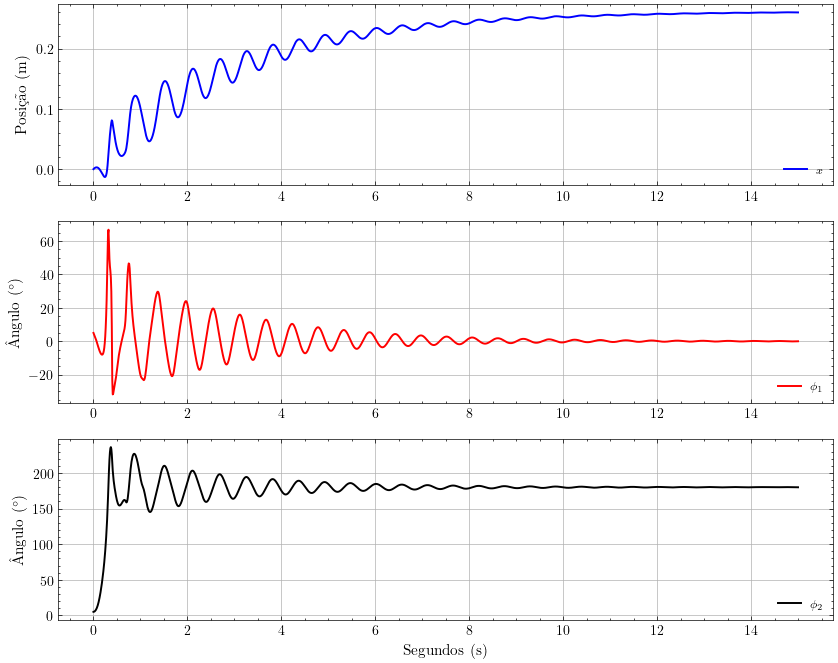

In [27]:
plt.style.use(['science'])
plt.figure(figsize=(10,8))
# plt.title('Resposta em malha aberta')
plt.subplot(3,1,1)
plt.plot(t, soluODE.T[0],'b',linewidth=1.4,label='$x$')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Posição (m)',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t, np.rad2deg(soluODE.T[1]),'r',linewidth=1.4,label='$\\phi_1$')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Ângulo ($^\\circ$)',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t, np.rad2deg(soluODE.T[2]),'k',linewidth=1.4,label='$\\phi_2$')
plt.xlabel('Segundos (s)',fontsize=11)
plt.ylabel('Ângulo ($^\\circ$)',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.savefig('Cap2_resposta_natural_ma_nl.png', dpi=250,bbox_inches='tight')
plt.show()

In [401]:
"""
plt.figure(figsize=(10,8))
# plt.title('Resposta em malha aberta')
plt.subplot(3,1,1)
plt.plot(t, soluODE.T[3],'b',linewidth=1.5,label='Pos. X')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Velocidade [m/s]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t, soluODE.T[4],'r',linewidth=1.5,label='Pos. pendulo inferior')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Velocidade Angular [rad/s]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t, soluODE.T[5],'g',linewidth=1.5,label='Pos. pendulo superior')
plt.xlabel('Segundos [s]',fontsize=11)
plt.ylabel('Velocidade Angular [rad/s]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.show()"""

"\nplt.figure(figsize=(10,8))\n# plt.title('Resposta em malha aberta')\nplt.subplot(3,1,1)\nplt.plot(t, soluODE.T[3],'b',linewidth=1.5,label='Pos. X')\n# plt.xlabel('Amostras [s]',fontsize=11)\nplt.ylabel('Velocidade [m/s]',fontsize=11)\nplt.grid(True)\nplt.legend(loc='upper right',fontsize='small')\n\nplt.subplot(3,1,2)\nplt.plot(t, soluODE.T[4],'r',linewidth=1.5,label='Pos. pendulo inferior')\n# plt.xlabel('Amostras [s]',fontsize=11)\nplt.ylabel('Velocidade Angular [rad/s]',fontsize=11)\nplt.grid(True)\nplt.legend(loc='upper right',fontsize='small')\n\nplt.subplot(3,1,3)\nplt.plot(t, soluODE.T[5],'g',linewidth=1.5,label='Pos. pendulo superior')\nplt.xlabel('Segundos [s]',fontsize=11)\nplt.ylabel('Velocidade Angular [rad/s]',fontsize=11)\nplt.grid(True)\nplt.legend(loc='upper right',fontsize='small')\nplt.show()"

# DINÂMICA NÃO LINEAR

$$
\begin{align}
q_p = \begin{bmatrix}
x\\ \phi_1
\\ \phi_2
\end{bmatrix},\;\;\;\;\;\dot{q}_p = \begin{bmatrix}
\dot{x}\\ \dot{\phi}_1
\\ \dot{\phi}_2
\end{bmatrix},\;\;\;\;\; \ddot{q}_p = \begin{bmatrix}
\ddot{x}\\ \ddot{\phi}_1
\\ \ddot{\phi}_2
\end{bmatrix},\;\;\;\;\; u_p = \begin{bmatrix}
u\\ 0
\\ 0
\end{bmatrix}
\end{align}
$$

In [402]:
# Matriz dos estados
#q = sym.Matrix([x,theta1,theta2])
q = sym.Matrix([x,phi1,phi2])

# Matriz das derivadas de estados
q_d = sym.Matrix([(x_d,phi1_d,phi2_d)])

# Matriz das 2º derivadas de estados
q_dd = sym.Matrix([(x_dd,phi1_dd,phi2_dd)])

# Matriz estados total
q_ef = sym.Matrix([q,q_d.transpose()])
q_ef1 = sym.Matrix([q_d.transpose(),q_dd.transpose()])
x_ = sym.Matrix([x,phi1,phi2,x_d,phi1_d,phi2_d])

$$
\begin{align}
H(q_p)\ddot{q_p} + N(q_p,\dot{q_p}) + W(q_p) = V(q_p)u_p
\end{align}
$$
$$
\begin{align}
\ddot{q_p} = -\frac{N(q_p,\dot{q_p})}{H(q_p)} - \frac{W(q_p)}{H(q_p)} + \frac{V(q_p)u_p}{H(q_p)}
\end{align}
$$



In [403]:
# Matriz H
H_nl = sym.Matrix((sym.diff(eq_x,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd)))
H_nl

Matrix([
[                        1.0*M + 1.0*m1 + 1.0*m2, 1.0*l1*m1*cos(phi1(t)) + 2.0*l1*m2*cos(phi1(t)),              1.0*l2*m2*cos(phi2(t))],
[1.0*l1*m1*cos(phi1(t)) + 2.0*l1*m2*cos(phi1(t)),            1.0*J1 + 1.0*l1**2*m1 + 4.0*l1**2*m2, 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))],
[                         1.0*l2*m2*cos(phi2(t)),             2.0*l1*l2*m2*cos(phi1(t) - phi2(t)),               1.0*J2 + 1.0*l2**2*m2]])

In [404]:
# Simplificação de H
# Constantes
a0, a1, a2, a3, a4, a5 = sym.symbols('a0 a1 a2 a3 a4 a5')

H_nl_simplificada = sym.Matrix(((a0, a1, a2),(a1 ,a3, a4),(a2,a4, a5)))
H_nl_simplificada

Matrix([
[a0, a1, a2],
[a1, a3, a4],
[a2, a4, a5]])

In [405]:
# Matriz H inversa:
#H_nl_inv = H_nl.inv()
H_nl_simplificada_inv = H_nl_simplificada.inv()
H_nl_simplificada_inv

Matrix([
[ (a3*a5 - a4**2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3), (-a1*a5 + a2*a4)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3),  (a1*a4 - a2*a3)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[(-a1*a5 + a2*a4)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3),  (a0*a5 - a2**2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3), (-a0*a4 + a1*a2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[ (a1*a4 - a2*a3)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3), (-a0*a4 + a1*a2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3),  (a0*a3 - a1**2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)]])

In [406]:
# Matriz N
N_nl = sym.Matrix(([sym.diff(eq_x,q_d)],[sym.diff(eqn_phi1,q_d)],[sym.diff(eqn_phi2,q_d)]))*q_d.transpose()
N_nl

Matrix([
[                                                                              f0*Derivative(x(t), t) - 2.0*l2*m2*sin(phi2(t))*Derivative(phi2(t), t)**2 + (-2.0*l1*m1*sin(phi1(t))*Derivative(phi1(t), t) - 4.0*l1*m2*sin(phi1(t))*Derivative(phi1(t), t))*Derivative(phi1(t), t)],
[(f1 + f2)*Derivative(phi1(t), t) + (-f2 - 2.0*l1*l2*m2*(Derivative(phi1(t), t) - Derivative(phi2(t), t))*sin(phi1(t) - phi2(t)) + 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t) + 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t))*Derivative(phi2(t), t)],
[       f2*Derivative(phi2(t), t) + (-f2 - 2.0*l1*l2*m2*(Derivative(phi1(t), t) - Derivative(phi2(t), t))*sin(phi1(t) - phi2(t)) - 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t) - 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t))*Derivative(phi1(t), t)]])

In [407]:
# Simplificação de N
N_nl_simplificada = sym.Matrix(((f0*x_d - a1*sym.sin(phi1)*phi1_d*phi1_d - a2*sym.sin(phi2)*phi2_d*phi2_d),
                                ((f1+f2)*phi1_d - f2*phi2_d +a4*phi2_d*phi2_d*sym.sin(phi1-phi2)),
                                (-f2*phi1_d+f2*phi2_d - a4*phi1_d*phi1_d*sym.sin(phi1-phi2))))
N_nl_simplificada

Matrix([
[   -a1*sin(phi1(t))*Derivative(phi1(t), t)**2 - a2*sin(phi2(t))*Derivative(phi2(t), t)**2 + f0*Derivative(x(t), t)],
[a4*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 - f2*Derivative(phi2(t), t) + (f1 + f2)*Derivative(phi1(t), t)],
[      -a4*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 - f2*Derivative(phi1(t), t) + f2*Derivative(phi2(t), t)]])

In [408]:
# Matriz W
W_nl = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)])
W_nl

Matrix([
[                             0],
[-g*l1*(m1 + 2*m2)*sin(phi1(t))],
[         -g*l2*m2*sin(phi2(t))]])

In [409]:
# Simplificação de W
W_nl_simplificada = sym.Matrix([0,-a1*g*sym.sin(phi1),-a2*g*sym.sin(phi2)])
W_nl_simplificada

Matrix([
[                 0],
[-a1*g*sin(phi1(t))],
[-a2*g*sin(phi2(t))]])

In [410]:
S_nl = N_nl_simplificada + W_nl_simplificada
S_nl

Matrix([
[                        -a1*sin(phi1(t))*Derivative(phi1(t), t)**2 - a2*sin(phi2(t))*Derivative(phi2(t), t)**2 + f0*Derivative(x(t), t)],
[-a1*g*sin(phi1(t)) + a4*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 - f2*Derivative(phi2(t), t) + (f1 + f2)*Derivative(phi1(t), t)],
[       -a2*g*sin(phi2(t)) - a4*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 - f2*Derivative(phi1(t), t) + f2*Derivative(phi2(t), t)]])

In [411]:
# Matriz V
V_nl = sym.Matrix([u, 0, 0])
V_nl

Matrix([
[u(t)],
[   0],
[   0]])

In [412]:
- H_nl_simplificada_inv*S_nl -H_nl_simplificada.inv() * V_nl

Matrix([
[  -(a1*a4 - a2*a3)*(-a2*g*sin(phi2(t)) - a4*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 - f2*Derivative(phi1(t), t) + f2*Derivative(phi2(t), t))/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3) - (-a1*a5 + a2*a4)*(-a1*g*sin(phi1(t)) + a4*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 - f2*Derivative(phi2(t), t) + (f1 + f2)*Derivative(phi1(t), t))/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3) - (a3*a5 - a4**2)*(-a1*sin(phi1(t))*Derivative(phi1(t), t)**2 - a2*sin(phi2(t))*Derivative(phi2(t), t)**2 + f0*Derivative(x(t), t))/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3) - (a3*a5 - a4**2)*u(t)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[-(-a0*a4 + a1*a2)*(-a2*g*sin(phi2(t)) - a4*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 - f2*Derivative(phi1(t), t) + f2*Derivative(phi2(t), t))/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3) - (a0*a5 - a2**2)*(-a1*g*sin(phi1(t)) + a4*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2

In [413]:
# Matrizes Não linear
Anl = sym.Matrix.vstack(q_d.transpose(), -H_nl_simplificada.inv() * S_nl)
Anl

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Derivative(x(t), t)],
[                                                                                                                                                                                                                                                                                                                                                                                          

In [414]:
Bnl = sym.Matrix.vstack(sym.zeros(3, 1), -H_nl_simplificada.inv() * V_nl)
Bnl

Matrix([
[                                                                              0],
[                                                                              0],
[                                                                              0],
[ -(a3*a5 - a4**2)*u(t)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[-(-a1*a5 + a2*a4)*u(t)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[ -(a1*a4 - a2*a3)*u(t)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)]])

### Posição para estabilização
$$
\begin{align} 
    \left\{\begin{matrix}
x_0=\dot{x}_0=\ddot{x}_0=0\\ 
\phi_{1_0}=\dot{\phi_{1_0}}=\ddot{\phi_{1_0}} =0\\ 
\phi_{2_0}=\dot{\phi_{2_0}}=\ddot{\phi_{2_0}} =0
\end{matrix}\right. \rightarrow x_0=\begin{bmatrix}
0\\ 0
\\ 0
\\ 0
\\ 0
\\ 0
\end{bmatrix} ,\;\; \left\{\begin{matrix}
u=0
\end{matrix}\right. \rightarrow u_0=[0]
\end{align}
$$
$$
\begin{align}
\cos(\phi_1) \approx 1 \\
\cos(\phi_2) \approx 1 \\
\cos(\phi_1 - \phi_2) \approx 1 \\
\sin(\phi_1) = \theta_1 \\
\sin(\phi_2) = \theta_2
\end{align}
$$

In [415]:
# Ponto de equilibrio - Linearização
#ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0,sym.cos(phi1):1,\
#            sym.cos(phi2):1,sym.cos(phi1-phi2):1,sym.sin(phi1-phi2):phi1-phi2,sym.sin(phi1):phi1,sym.sin(phi2):phi2}


In [416]:
# Ponto de equilibrio - Linearização
ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0}#, sym.cos(phi1):1,sym.cos(phi2):1, sym.cos(phi1-phi2):1}

In [417]:
# Valor dos parâmetros do sistema:


#rev_parametros_valores = {g:9.81, f0:0.01, f1:0.007, f2:0.007, a0:3, }
rev_parametros_valores = {g:9.81, f0:0.01, f1:0.007, f2:0.007, a0:3, a1:0.15, a2:0.05, a3:0.01333, a4:0.005, a5:0.00333}


In [418]:
# Matriz A Linear

A_0 = Anl.jacobian(q_ef)
A_0


Matrix([
[0,                                                                                                                                                                                                                                                                                                                                                                                                         0,                                                                                                                                                                                                                                                                                                                                                                                                         0,                                                                             1,                                                                                                                       

In [419]:
A_1 = A_0.subs(ponto_eq)
A_1


Matrix([
[0,                                                                              0,                                                                              0,                                                                             1,                                                                                                                                                                 0,                                                                                                                                                           0],
[0,                                                                              0,                                                                              0,                                                                             0,                                                                                                                                                                 1,                      

In [420]:
A_1[19]

a1*g*(-a1*a5 + a2*a4)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)

In [421]:
A_2 = A_1.subs(rev_parametros_valores)
A=np.matrix(A_2).astype(np.float64)
A_2

Matrix([
[0,                 0,                 0,                    1,                 0,                  0],
[0,                 0,                 0,                    0,                 1,                  0],
[0,                 0,                 0,                    0,                 0,                  1],
[0, -14.7346659068015,  1.64374696488701, -0.00778148791774192,   0.1636452660264, -0.093551714312088],
[0,  442.335261089952, -147.641942953923,     0.10013364530616, -6.31544305626348,   4.21123182443904],
[0, -442.925828861768,  344.301010968548,  -0.0335116608539655,  9.12761320720642,  -7.02059261459183]])

In [422]:
# Matriz B Linear
B_0 = Bnl.jacobian([u])
B_1 = B_0.subs(ponto_eq)
B_2 = B_1.subs(rev_parametros_valores)
B = np.matrix(B_2).astype(np.float64)
B_2



Matrix([
[                 0],
[                 0],
[                 0],
[-0.778148791774192],
[   10.013364530616],
[ -3.35116608539655]])

In [423]:
# Matriz C e D

C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

# Matriz D
D = np.zeros((3,1))

### Sistema Contínuo

In [424]:
# Criando o sistema em State Space
sys_c_ma = ct.ss(A,B,C,D)
sys_c_ma



StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -1.47346659e+01,  1.64374696e+00,
        -7.78148792e-03,  1.63645266e-01, -9.35517143e-02],
       [ 0.00000000e+00,  4.42335261e+02, -1.47641943e+02,
         1.00133645e-01, -6.31544306e+00,  4.21123182e+00],
       [ 0.00000000e+00, -4.42925829e+02,  3.44301011e+02,
        -3.35116609e-02,  9.12761321e+00, -7.02059261e+00]]), array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.77814879],
       [10.01336453],
       [-3.35116609]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]]), array([[0.],
       [0.],
       [0.]]

In [425]:
# Matriz de controlabilidade
Co = ct.ctrb(A, B) # Sis Contínuo

# Ranking da matriz de controlabilidade
ranking_Co = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',ranking_Co)
Co

Rank da Matriz de controlabilidade: 6


array([[ 0.00000000e+00, -7.78148792e-01,  1.95820219e+00,
        -1.76492122e+02,  2.96076898e+03, -1.34580409e+05],
       [ 0.00000000e+00,  1.00133645e+01, -7.74292896e+01,
         5.89732009e+03, -1.18394851e+05,  5.15308394e+06],
       [ 0.00000000e+00, -3.35116609e+00,  1.14951367e+02,
        -7.10282460e+03,  1.77573714e+05, -7.38501941e+06],
       [-7.78148792e-01,  1.95820219e+00, -1.76492122e+02,
         2.96076898e+03, -1.34580409e+05,  3.57160109e+06],
       [ 1.00133645e+01, -7.74292896e+01,  5.89732009e+03,
        -1.18394851e+05,  5.15308394e+06, -1.42245059e+08],
       [-3.35116609e+00,  1.14951367e+02, -7.10282460e+03,
         1.77573714e+05, -7.38501941e+06,  2.12466027e+08]])

In [426]:
# Matriz de observabilidade
Ob = ct.obsv(A,C)

ranking_Ob = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',ranking_Ob)
Ob

Rank da Matriz de observabilidade: 6


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -1.47346659e+01,  1.64374696e+00,
        -7.78148792e-03,  1.63645266e-01, -9.35517143e-02],
       [ 0.00000000e+00,  4.42335261e+02, -1.47641943e+02,
         1.00133645e-01, -6.31544306e+00,  4.21123182e+00],
       [ 0.00000000e+00, -4.42925829e+02,  3.443

### Sistema Discreto


In [427]:
# Definindo o sistema discreto
Ts = 0.01
sys_d_ma = ct.c2d(sys_c_ma, Ts,method='zoh')

Ad = sys_d_ma.A
Bd = sys_d_ma.B
Cd = sys_d_ma.C
Dd = sys_d_ma.D

print(sys_d_ma)

<StateSpace>: sys[58]$sampled
Inputs (1): ['u[0]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 1.00000000e+00 -7.21224509e-04  7.41739637e-05  9.99961348e-03
       5.50504293e-06 -4.23619552e-06]
     [ 0.00000000e+00  1.02146819e+00 -7.04354209e-03  4.90128786e-06
       9.76726874e-03  1.78912536e-04]
     [ 0.00000000e+00 -2.11306263e-02  1.01668014e+00 -1.51221129e-06
       3.67887082e-04  9.71743702e-03]
     [ 0.00000000e+00 -1.43029569e-01  1.41655327e-02  9.99922881e-01
       8.41731759e-04 -8.08383405e-04]
     [ 0.00000000e+00  4.24109017e+00 -1.38045071e+00  9.71998429e-04
       9.61417410e-01  3.28321603e-02]
     [ 0.00000000e+00 -4.14135213e+00  3.29140534e+00 -2.88797812e-04
       6.52427628e-02  9.50007371e-01]]

B = [[-3.86523238e-05]
     [ 4.90128786e-04]
     [-1.51221129e-04]
     [-7.71186695e-03]
     [ 9.71998429e-02]
     [-2.88797812e-02]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
   

In [428]:
# Polos do sistema discreto
#ct.poles(sys_d_ma)
plt.figure(figsize=(8,8))
ct.pole_zero_plot(sys_d_ma, grid=True, color='r',marker_size=9,  xlim=[0,1])
#plt.savefig('Cap2_Pzmap_sys_d_ma.png', dpi=200,bbox_inches='tight')

Error in callback <function _draw_all_if_interactive at 0x000002A193F20220> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Pole/zero plot for sys[58]$sampled'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpmvvi1oto db80167f79d4dfd51c08682b969a5579.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (MiKTeX 24.1) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(db80167f79d4dfd51c08682b969a5579.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-04>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Program Files\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Program Files\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Program Files\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Program Files\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Program Files\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Program Files\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Program Files\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Program Files\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Program Files\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Program Files\MiKTeX\tex/latex/amsfonts\amssymb.sty
(C:\Program Files\MiKTeX\tex/latex/amsfonts\amsfonts.sty))
(C:\Program Files\MiKTeX\tex/latex/underscore\underscore.sty)
(C:\Program Files\MiKTeX\tex/latex/firstaid\underscore-ltx.sty)
(C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
No file db80167f79d4dfd51c08682b969a5579.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.29 ...family Pole/zero plot for sys[58]$sampled}
                                                  %
No pages of output.
Transcript written on C:\Users\mateu\.matplotlib\tex.cache\db\80\tmpmvvi1oto\db
80167f79d4dfd51c08682b969a5579.log.




RuntimeError: latex was not able to process the following string:
b'Pole/zero plot for sys[58]$sampled'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpw_m_su4z db80167f79d4dfd51c08682b969a5579.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (MiKTeX 24.1) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(db80167f79d4dfd51c08682b969a5579.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-04>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Program Files\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Program Files\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Program Files\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Program Files\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Program Files\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Program Files\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Program Files\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Program Files\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Program Files\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Program Files\MiKTeX\tex/latex/amsfonts\amssymb.sty
(C:\Program Files\MiKTeX\tex/latex/amsfonts\amsfonts.sty))
(C:\Program Files\MiKTeX\tex/latex/underscore\underscore.sty)
(C:\Program Files\MiKTeX\tex/latex/firstaid\underscore-ltx.sty)
(C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
No file db80167f79d4dfd51c08682b969a5579.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.29 ...family Pole/zero plot for sys[58]$sampled}
                                                  %
No pages of output.
Transcript written on C:\Users\mateu\.matplotlib\tex.cache\db\80\tmpw_m_su4z\db
80167f79d4dfd51c08682b969a5579.log.




<Figure size 800x800 with 1 Axes>

In [429]:
# Matriz de controlabilidade

Cod = ct.ctrb(Ad, Bd) # Sis Discreto

# Ranking da matriz de controlabilidade
ranking_Cod = np.linalg.matrix_rank(Cod)    
print('Rank da Matriz de controlabilidade:',ranking_Cod)
Cod

Rank da Matriz de controlabilidade: 6


array([[-3.86523238e-05, -1.15475292e-04, -1.92707187e-04,
        -2.71764346e-04, -3.54017885e-04, -4.40867480e-04],
       [ 4.90128786e-04,  1.44588833e-03,  2.40130117e-03,
         3.40090771e-03,  4.48686313e-03,  5.70163957e-03],
       [-1.51221129e-04, -4.08967472e-04, -6.40984295e-04,
        -8.95910325e-04, -1.21793913e-03, -1.65049878e-03],
       [-7.71186695e-03, -7.67835513e-03, -7.79148673e-03,
        -8.04267541e-03, -8.43125010e-03, -8.96347869e-03],
       [ 9.71998429e-02,  9.47813734e-02,  9.70382150e-02,
         1.03581229e-01,  1.14313766e-01,  1.29390904e-01],
       [-2.88797812e-02, -2.36197174e-02, -2.35869000e-02,
        -2.81288103e-02, -3.69954892e-02, -5.02758181e-02]])

In [430]:
# Matriz de observabilidade

Obd = ct.obsv(Ad, Cd) # Sis Discreto

ranking_Obd = np.linalg.matrix_rank(Obd)    
print('Rank da Matriz de observabilidade:',ranking_Obd)
Obd

Rank da Matriz de observabilidade: 6


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00, -7.21224509e-04,  7.41739637e-05,
         9.99961348e-03,  5.50504293e-06, -4.23619552e-06],
       [ 0.00000000e+00,  1.02146819e+00, -7.04354209e-03,
         4.90128786e-06,  9.76726874e-03,  1.78912536e-04],
       [ 0.00000000e+00, -2.11306263e-02,  1.01668014e+00,
        -1.51221129e-06,  3.67887082e-04,  9.71743702e-03],
       [ 1.00000000e+00, -2.84884919e-03,  2.74772509e-04,
         1.99984587e-02,  1.19211922e-05, -1.55716469e-05],
       [ 0.00000000e+00,  1.08422833e+00, -2.72500735e-02,
         1.93601712e-05,  1.93764622e-02,  6.04953088e-04],
       [ 0.00000000e+00, -8.17502206e-02,  1.065

# Controlador LQR

## Sintonia LQR

In [431]:
# Sintonia do Contolador Contínuo
Q = np.array([[200,0,0,0,0,0],[0,200,0,0,0,0],[0,0,200,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
R1 = np.array([0.01])
R2 = np.array([0.1])
R3 = np.array([1])
R4 = np.array([400])


## LQR - Sistema Contínuo Linear 

In [432]:
Kc1, Sc1, Pc1 = ct.lqr(sys_c_ma, Q, R1) # K - Ganhos do LQR
Kc2, Sc2, Pc2 = ct.lqr(sys_c_ma, Q, R2) # K - Ganhos do LQR
Kc3, Sc3, Pc3 = ct.lqr(sys_c_ma, Q, R3) # K - Ganhos do LQR
#Kc4, Sc4, Pc4 = ct.lqr(sys_c_ma, Q, R4) # K - Ganhos do LQR

In [433]:
# Sistema em Malha fechada - Contínuo

# LQR para regulação
sys_c_mf_1 = ct.ss(A - B*Kc1, B, C, D)
sys_c_mf_2 = ct.ss(A - B*Kc2, B, C, D)
sys_c_mf_3 = ct.ss(A - B*Kc3, B, C, D)
#sys_c_mf_4 = ct.ss(A - B*Kc4, B, C, D)


# LQR para tracking
sys_c_mf_1_t = ct.ss(A - B*Kc1, B*Kc1[0][0], C, D)
sys_c_mf_2_t = ct.ss(A - B*Kc2, B*Kc2[0][0], C, D)
sys_c_mf_3_t = ct.ss(A - B*Kc3, B*Kc3[0][0], C, D)
#sys_c_mf_4_t = ct.ss(A - B*Kc4, B*Kc4[0][0], C, D)

In [434]:
ct.poles(sys_c_ma)

array([ 0.00000000e+00+0.j, -3.27684988e+01+0.j, -1.18052378e+01+0.j,
        2.00021693e+01+0.j,  1.12310836e+01+0.j, -3.33333308e-03+0.j])

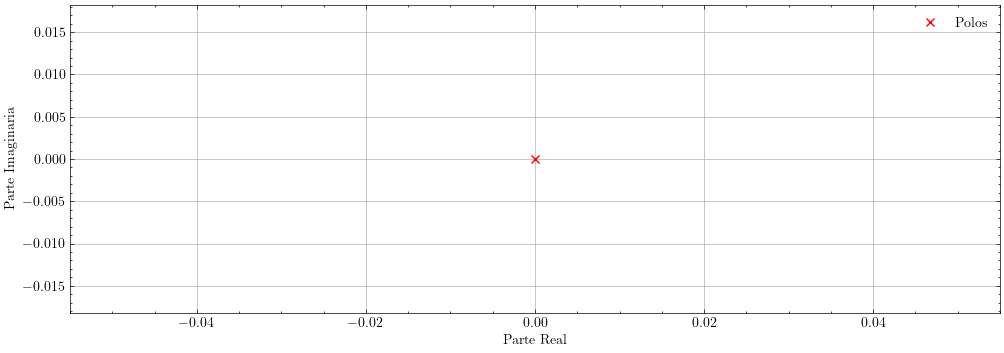

In [435]:
#  REPRESENTAÇÃO DOS POLOS NO PLANO CONTINUO
novo_sys_real = np.real(Pc)
novo_sys_imaginario = np.imag(Pc)

# Gráfico dos polos no plano complexo
plt.figure(figsize=(12, 4))
plt.plot(novo_sys_real,novo_sys_imaginario, 'rx', markersize=6, label='Polos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [436]:
# Simulações

# Simular o sistema linear contínuo para condições iniciais
Ts = 0.01
t_c_mf = np.arange(0, 5, Ts) 
x0_c_mf = np.array([[0.0],[np.deg2rad(5)],[np.deg2rad(5)],[0],[0],[0]])

t_cmf_1,y_cmf_1 = ct.initial_response(sys_c_mf_1, t_c_mf, x0_c_mf) # resposta inicial
t_cmf_2,y_cmf_2 = ct.initial_response(sys_c_mf_2, t_c_mf, x0_c_mf) # resposta inicial
t_cmf_3,y_cmf_3 = ct.initial_response(sys_c_mf_3, t_c_mf, x0_c_mf) # resposta inicial
#_cmf_4,y_cmf_4 = ct.initial_response(sys_c_mf_4, t_c_mf, x0_c_mf) # resposta inicial

# TRacking
t_cmf_1_t,y_cmf_1_t = ct.step_response(sys_c_mf_1_t, t_c_mf, x0_c_mf) # resposta degrau
t_cmf_2_t,y_cmf_2_t = ct.step_response(sys_c_mf_2_t, t_c_mf, x0_c_mf) # resposta ao degrau
t_cmf_3_t,y_cmf_3_t = ct.step_response(sys_c_mf_3_t, t_c_mf, x0_c_mf) # resposta ao degrau
#t_cmf_4_t,y_cmf_4_t = ct.step_response(sys_c_mf_4_t, t_c_mf, x0_c_mf) # resposta ao degrau

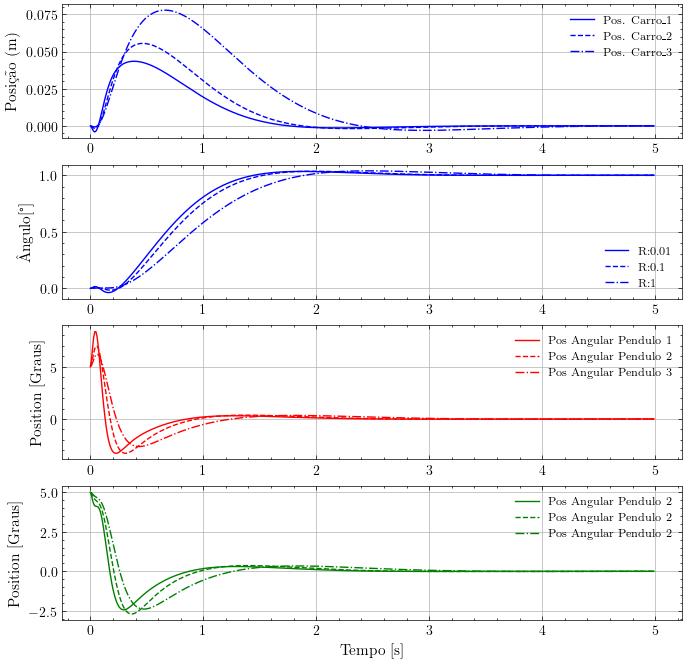

In [437]:
plt.figure(figsize=(8,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(4,1,1)
plt.plot(t_cmf_1,y_cmf_1[0],'-b',linewidth=1,label='Pos. Carro_1')
plt.plot(t_cmf_2,y_cmf_2[0],'--b',linewidth=1,label='Pos. Carro_2')
plt.plot(t_cmf_3,y_cmf_3[0],'-.b',linewidth=1,label='Pos. Carro_3')
#plt.plot(t_cmf_4,y_cmf_4[0],':b',linewidth=1,label='Pos. Carro_4')
##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Posição (m)',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,2)
plt.plot(t_cmf_1_t,y_cmf_1_t[0][0],'-b',linewidth=1,label='R:0.01')
plt.plot(t_cmf_2_t,y_cmf_2_t[0][0],'--b',linewidth=1,label='R:0.1')
plt.plot(t_cmf_3_t,y_cmf_3_t[0][0],'-.b',linewidth=1,label='R:1')
#plt.plot(t_cmf_4_t,y_cmf_4_t[0][0],':b',linewidth=1,label='R:10')
##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(4,1,3)
plt.plot(t_cmf_1,y_cmf_1[1]*180/np.pi,'-r',linewidth=1,label='Pos Angular Pendulo 1')
plt.plot(t_cmf_2,y_cmf_2[1]*180/np.pi,'--r',linewidth=1,label='Pos Angular Pendulo 2')
plt.plot(t_cmf_3,y_cmf_3[1]*180/np.pi,'-.r',linewidth=1,label='Pos Angular Pendulo 3')
#plt.plot(t_cmf_4,y_cmf_4[1]*180/np.pi,':r',linewidth=1,label='Pos Angular Pendulo 4')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,4)
plt.plot(t_cmf_1,y_cmf_1[2]*180/np.pi,'-g',linewidth=1,label='Pos Angular Pendulo 2')
plt.plot(t_cmf_2,y_cmf_2[2]*180/np.pi,'--g',linewidth=1,label='Pos Angular Pendulo 2')
plt.plot(t_cmf_3,y_cmf_3[2]*180/np.pi,'-.g',linewidth=1,label='Pos Angular Pendulo 2')
#plt.plot(t_cmf_4,y_cmf_4[2]*180/np.pi,':g',linewidth=1,label='Pos Angular Pendulo 2')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

#plt.savefig('Cap4_lqr_L_caso3_sys_d_mf.png', dpi=500,bbox_inches='tight')
plt.show()

## LQR - Sistema Discreto Linear

In [438]:
# Inicialiando o LQR em tempo discreto

Kd1, Sd1, Pd1 = ct.dlqr(sys_d_ma, Q, R1) # K - Ganhos do LQR - Caso 1
Kd2, Sd2, Pd2 = ct.dlqr(sys_d_ma, Q, R2) # K - Ganhos do LQR
Kd3, Sd3, Pd3 = ct.dlqr(sys_d_ma, Q, R3) # K - Ganhos do LQR
Kd4, Sd4, Pd4 = ct.dlqr(sys_d_ma, Q, R4) # K - Ganhos do LQR



In [439]:
# Sistema em Malha fechada - Discreto

# LQR para regulação
sys_d_mf_1 = ct.ss(Ad - Bd*Kd1, Bd, Cd, Dd, Ts)
sys_d_mf_2 = ct.ss(Ad - Bd*Kd2, Bd, Cd, Dd, Ts)
sys_d_mf_3 = ct.ss(Ad - Bd*Kd3, Bd, Cd, Dd, Ts)
sys_d_mf_4 = ct.ss(Ad - Bd*Kd4, Bd, Cd, Dd, Ts)


# LQR para tracking
sys_d_mf_1_t = ct.ss(Ad - Bd*Kd1, Bd*Kd1[0][0], Cd, Dd, Ts)
sys_d_mf_2_t = ct.ss(Ad - Bd*Kd2, Bd*Kd2[0][0], Cd, Dd, Ts)
sys_d_mf_3_t = ct.ss(Ad - Bd*Kd3, Bd*Kd3[0][0], Cd, Dd, Ts)
sys_d_mf_4_t = ct.ss(Ad - Bd*Kd4, Bd*Kd4[0][0], Cd, Dd, Ts)


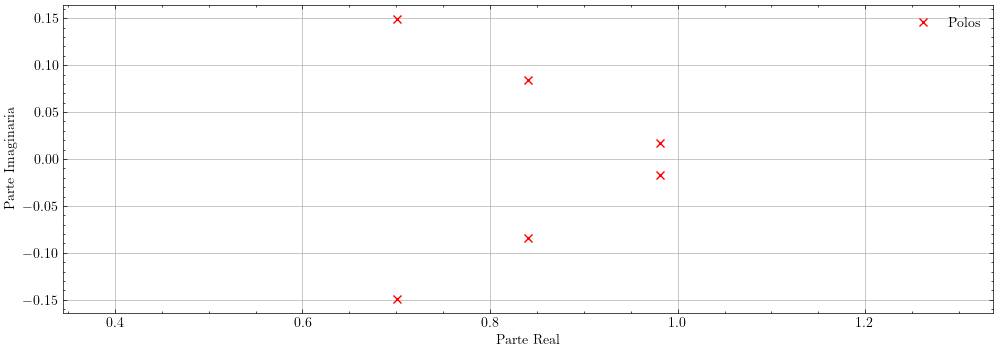

In [440]:
#  REPRESENTAÇÃO DOS POLOS NO PLANO DISCRETO

sys_discreto_real = np.real(Pd1)
sys_discreto_imaginario = np.imag(Pd1)

# Gráfico dos polos no plano complexo
plt.figure(figsize=(12, 4))
plt.plot(sys_discreto_real,sys_discreto_imaginario, 'rx', markersize=6, label='Polos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

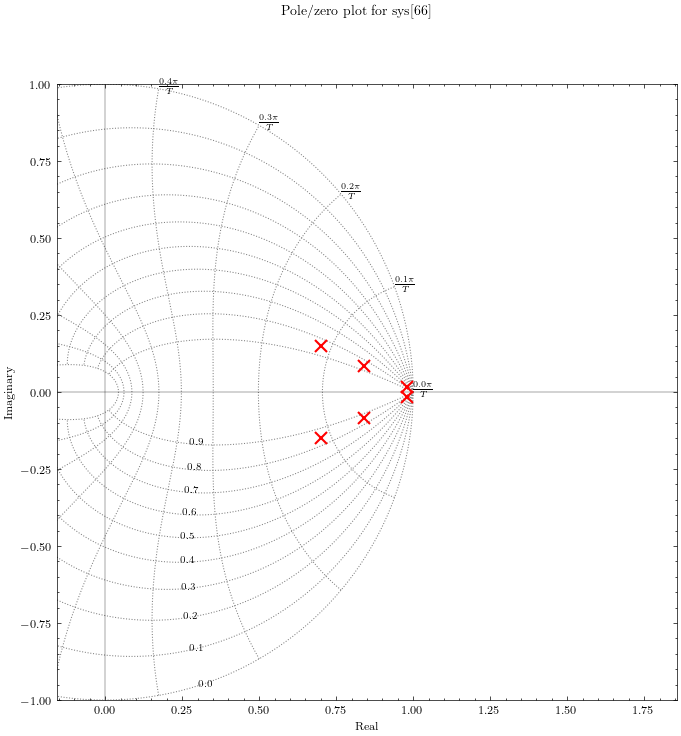

In [441]:
plt.figure(figsize=(8,8))
ct.pole_zero_plot(sys_d_mf_1, grid=True, color='r',marker_size=9,  xlim=[0.7,1],ylim=[-1,1])
plt.savefig('Cap4_Pzmap_sys_d_mf.png', dpi=300,bbox_inches='tight')

In [455]:
# Simulações

# Simular o sistema linear discreto para condições iniciais

t_d_mf = np.arange(0, 6, Ts) 
x0_d_mf = np.array([[0.2],[np.deg2rad(5)],[np.deg2rad(5)],[0],[0],[0]])

t_dmf_1, y_dmf_1 ,x_dmf_1 = ct.initial_response(sys_d_mf_1, t_d_mf, x0_d_mf, return_x=True) # resposta inicial
t_dmf_2, y_dmf_2,x_dmf_2 = ct.initial_response(sys_d_mf_2, t_d_mf, x0_d_mf, return_x=True) # resposta inicial
t_dmf_3, y_dmf_3,x_dmf_3 = ct.initial_response(sys_d_mf_3, t_d_mf, x0_d_mf, return_x=True) # resposta inicial
t_dmf_4, y_dmf_4,x_dmf_4 = ct.initial_response(sys_d_mf_4, t_d_mf, x0_d_mf, return_x=True) # resposta inicial

# Tracking
t_dmf_1_t,y_dmf_1_t, x_dmf_t1 = ct.step_response(sys_d_mf_1_t, t_d_mf, x0_d_mf, return_x=True) # resposta degrau
t_dmf_2_t,y_dmf_2_t, x_dmf_t2  = ct.step_response(sys_d_mf_2_t, t_d_mf, x0_d_mf, return_x=True) # resposta ao degrau
t_dmf_3_t,y_dmf_3_t, x_dmf_t3  = ct.step_response(sys_d_mf_3_t, t_d_mf, x0_d_mf, return_x=True) # resposta a/o degrau
t_dmf_4_t,y_dmf_4_t, x_dmf_t4  = ct.step_response(sys_d_mf_4_t, t_d_mf, x0_d_mf, return_x=True) # resposta a/o degrau

In [456]:
# Esforço de controle

# Regulação
sinal_de_controle_d1 = -(Kd1 @ x_dmf_1.T.T).flatten()
sinal_de_controle_d2 = -(Kd2 @ x_dmf_2.T.T).flatten()
sinal_de_controle_d3 = -(Kd3 @ x_dmf_3.T.T).flatten()
sinal_de_controle_d4 = -(Kd4 @ x_dmf_4.T.T).flatten()

# Tracking
sinal_de_controle_d1_t = -(Kd1 @ x_dmf_t1[:,0].T.T).flatten()
sinal_de_controle_d2_t = -(Kd2 @ x_dmf_t2[:,0].T.T).flatten()
sinal_de_controle_d3_t = -(Kd3 @ x_dmf_t3[:,0].T.T).flatten()
sinal_de_controle_d4_t = -(Kd4 @ x_dmf_t4[:,0].T.T).flatten()


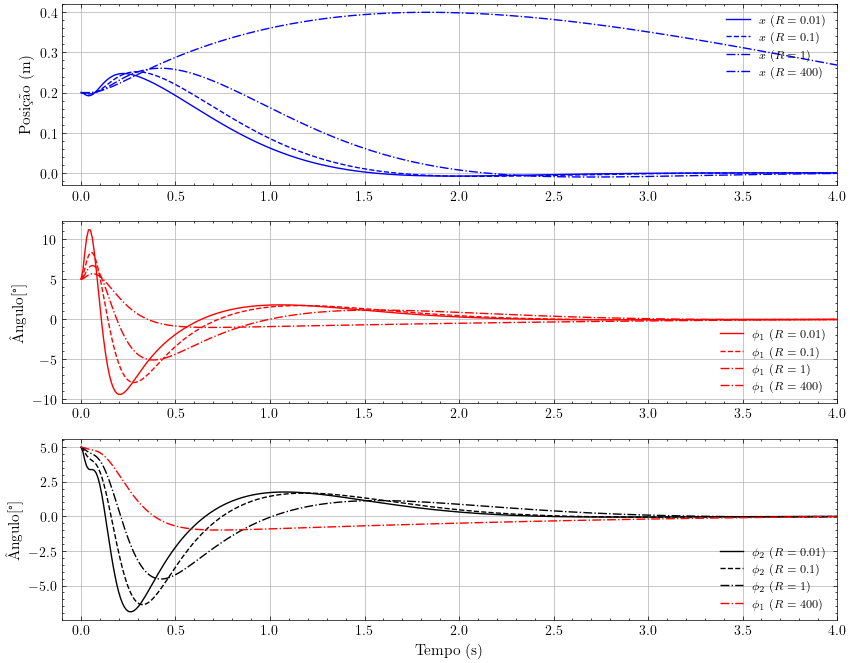

In [457]:
# Plotando sinais de Regulação
plt.figure(figsize=(10,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)
plt.plot(t_dmf_1,y_dmf_1[0],'-b',linewidth=1,label='$x$ ($R=0.01$)')
plt.plot(t_dmf_2,y_dmf_2[0],'--b',linewidth=1,label='$x$ ($R=0.1$)')
plt.plot(t_dmf_3,y_dmf_3[0],'-.b',linewidth=1,label='$x$ ($R=1$)')
plt.plot(t_dmf_4,y_dmf_4[0],'-.b',linewidth=1,label='$x$ ($R=400$)')
plt.xlim([-0.1, 4])
plt.ylabel('Posição (m)',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t_dmf_1,y_dmf_1[1]*180/np.pi,'-r',linewidth=1,label='$\\phi_1$ ($R=0.01$)')
plt.plot(t_dmf_2,y_dmf_2[1]*180/np.pi,'--r',linewidth=1,label='$\\phi_1$ ($R=0.1$)')
plt.plot(t_dmf_3,y_dmf_3[1]*180/np.pi,'-.r',linewidth=1,label='$\\phi_1$ ($R=1$)')
plt.plot(t_dmf_4,y_dmf_4[1]*180/np.pi,'-.r',linewidth=1,label='$\\phi_1$ ($R=400$)')
plt.xlim([-0.1, 4])
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t_dmf_1,y_dmf_1[2]*180/np.pi,'-k',linewidth=1,label='$\\phi_2$ ($R=0.01$)')
plt.plot(t_dmf_2,y_dmf_2[2]*180/np.pi,'--k',linewidth=1,label='$\\phi_2$ ($R=0.1$)')
plt.plot(t_dmf_3,y_dmf_3[2]*180/np.pi,'-.k',linewidth=1,label='$\\phi_2$ ($R=1$)')
plt.plot(t_dmf_4,y_dmf_4[2]*180/np.pi,'-.r',linewidth=1,label='$\\phi_1$ ($R=400$)')
plt.xlim([-0.1, 4])
plt.xlabel('Tempo (s)',fontsize=11)
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

#plt.savefig('Cap4_lqr_L_caso1_sys_d_mf.png', dpi=400,bbox_inches='tight')
plt.show()

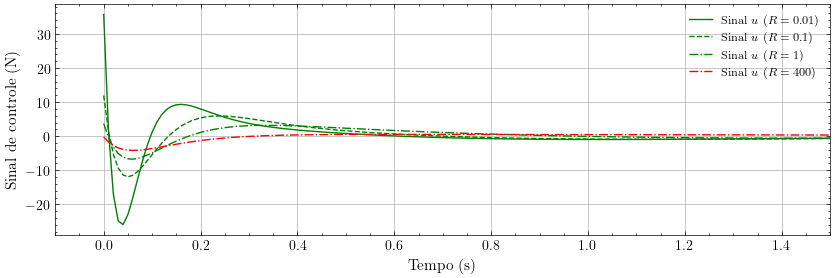

In [458]:
# Sinal de controle - Regulação
plt.figure(figsize=(10,3))
plt.plot(t_dmf_1, sinal_de_controle_d1,'-g', label = 'Sinal $u$ ($R=0.01$)')
plt.plot(t_dmf_2, sinal_de_controle_d2,'--g', label = 'Sinal $u$ ($R=0.1$)')
plt.plot(t_dmf_3, sinal_de_controle_d3,'-.g', label = 'Sinal $u$ ($R=1$)')
plt.plot(t_dmf_4, sinal_de_controle_d4,'-.r', label = 'Sinal $u$ ($R=400$)')
#plt.plot(t_dmf_1_t, sinal_de_controle_d1_t,':r', label = '$Sinal\\;de\\;controle$ $(u)$')
#plt.plot(t_dmf_4_t, sinal_de_controle_d4_t,'-.b', label = '$Sinal\\;de\\;controle$ $(u)$')
plt.xlim([-0.1, 1.5])
plt.ylabel('Sinal de controle (N)',fontsize=11, color='k')
plt.xlabel('Tempo (s)',fontsize=11)
plt.legend(loc='upper right',fontsize='small')
plt.grid(True)

#plt.savefig('Cap4_lqr_L_sinaisU_sys_d_mf.png', dpi=400,bbox_inches='tight')
plt.show()

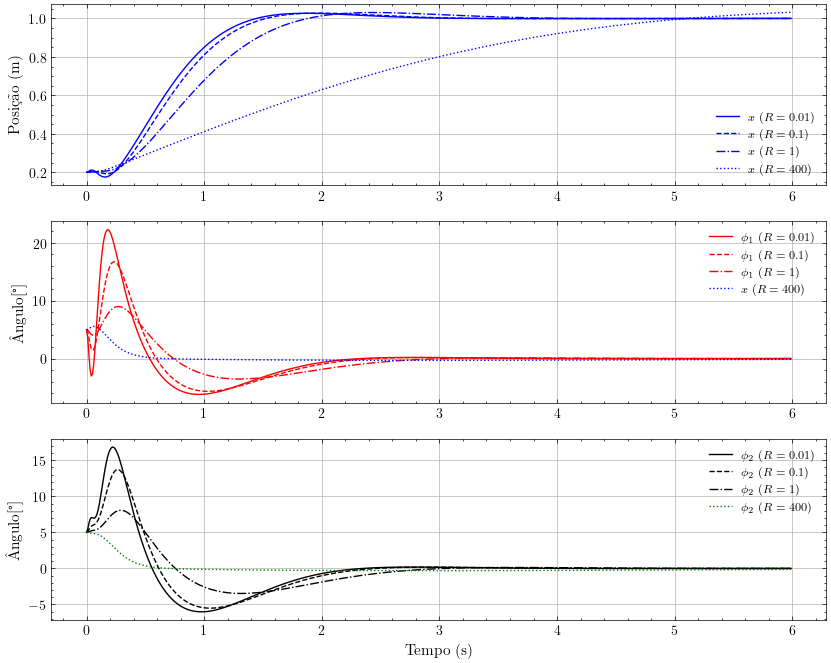

In [465]:
# Plotando sinais de Tracking
plt.figure(figsize=(10,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)
plt.plot(t_dmf_1_t,y_dmf_1_t[0][0],'-b',linewidth=1,label='$x$ ($R=0.01$)')
plt.plot(t_dmf_2_t,y_dmf_2_t[0][0],'--b',linewidth=1,label='$x$ ($R=0.1$)')
plt.plot(t_dmf_3_t,y_dmf_3_t[0][0],'-.b',linewidth=1,label='$x$ ($R=1$)')
plt.plot(t_dmf_4_t,y_dmf_4_t[0][0],':b',linewidth=1,label='$x$ ($R=400$)')
##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Posição (m)',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t_dmf_1_t,y_dmf_1_t[1][0]*180/np.pi,'-r',linewidth=1,label='$\\phi_1$ ($R=0.01$)')
plt.plot(t_dmf_2_t,y_dmf_2_t[1][0]*180/np.pi,'--r',linewidth=1,label='$\\phi_1$ ($R=0.1$)')
plt.plot(t_dmf_3_t,y_dmf_3_t[1][0]*180/np.pi,'-.r',linewidth=1,label='$\\phi_1$ ($R=1$)')
plt.plot(t_dmf_4_t,y_dmf_4_t[1][0]*180/np.pi,':b',linewidth=1,label='$x$ ($R=400$)')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t_dmf_1_t,y_dmf_1_t[2][0]*180/np.pi,'-k',linewidth=1,label='$\\phi_2$ ($R=0.01$)')
plt.plot(t_dmf_2_t,y_dmf_2_t[2][0]*180/np.pi,'--k',linewidth=1,label='$\\phi_2$ ($R=0.1$)')
plt.plot(t_dmf_3_t,y_dmf_3_t[2][0]*180/np.pi,'-.k',linewidth=1,label='$\\phi_2$ ($R=1$)')
plt.plot(t_dmf_4_t,y_dmf_4_t[2][0]*180/np.pi,':g',linewidth=1,label='$\\phi_2$ ($R=400$)')
plt.xlabel('Tempo (s)',fontsize=11)
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

#plt.savefig('Cap4_lqr_L_Tracking_caso3_sys_d_mf.png', dpi=400,bbox_inches='tight')
plt.show()

In [454]:
np.min(y_dmf_4_t[0][0])

0.19993129590835598

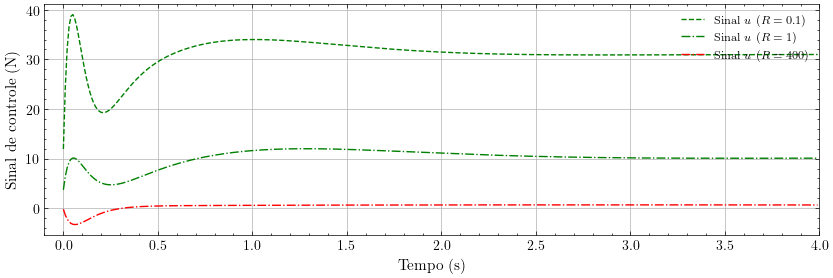

In [452]:
# Sinal de controle - Tracking
plt.figure(figsize=(10,3))
#plt.plot(t_dmf_1, sinal_de_controle_d1_t,'-g', label = 'Sinal $u$ ($R=0.01$)')
plt.plot(t_dmf_2, sinal_de_controle_d2_t,'--g', label = 'Sinal $u$ ($R=0.1$)')
plt.plot(t_dmf_3, sinal_de_controle_d3_t,'-.g', label = 'Sinal $u$ ($R=1$)')
plt.plot(t_dmf_4, sinal_de_controle_d4_t,'-.r', label = 'Sinal $u$ ($R=400$)')
#plt.plot(t_dmf_1_t, sinal_de_controle_d1_t,':r', label = '$Sinal\\;de\\;controle$ $(u)$')
#plt.plot(t_dmf_4_t, sinal_de_controle_d4_t,'-.b', label = '$Sinal\\;de\\;controle$ $(u)$')
plt.xlim([-0.1, 4])
plt.ylabel('Sinal de controle (N)',fontsize=11, color='k')
plt.xlabel('Tempo (s)',fontsize=11)
plt.legend(loc='upper right',fontsize='small')
plt.grid(True)
#
#plt.savefig('Cap4_lqr_L_sinaisU_Tracking_sys_d_mf.png', dpi=400,bbox_inches='tight')
plt.show()

In [453]:
np.max(sinal_de_controle_d4_t)

0.6735374189533084

## LQR Não Linear

In [466]:
A_nolinear = sym.Matrix(((0,0,0,1,0,0),(0,0,0,0,1,0),(0,0,0,0,0,1)))
A_nolinear

Matrix([
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 1]])

In [467]:
Anl_0 = Anl.jacobian(q_ef)
Anl_1 = Anl_0.subs(rev_parametros_valores)
Anl_1


Matrix([
[0,                                                                                                                                                                                                                                    0,                                                                                                                                                                                                                                      0,                    1,                                                                                                                                          0,                                                                                                                                           0],
[0,                                                                                                                                                                                                                          

In [468]:
Bnl_1 = Bnl.subs(rev_parametros_valores)
Bnl_2 = Bnl_1.subs({u:1})
Bnl_2

Matrix([
[                 0],
[                 0],
[                 0],
[-0.778148791774192],
[   10.013364530616],
[ -3.35116608539655]])

In [469]:
# Dinâmica não linear do sistema
def nlodek(xsr_, t, K, Anl, Bnl):
    A_nlode = np.array(Anl.subs({x: xsr_[0], phi1: xsr_[1], phi2: xsr_[2], x_d: xsr_[3], phi1_d: xsr_[4], phi2_d: xsr_[5]})).astype(np.float64)
    B_nlode = np.array(Bnl.subs({x: xsr_[0], phi1: xsr_[1], phi2: xsr_[2], x_d: xsr_[3], phi1_d: xsr_[4], phi2_d: xsr_[5]})).astype(np.float64)
   
    u_lqr =-K@xsr_  # Controlador LQR
    
    dxdt = np.dot(A_nlode, xsr_) + np.dot(B_nlode, u_lqr)
    return dxdt.flatten()



In [519]:
# LQR - Regulação
# # Simular modelo não linear com odeint
x0 = [0.3, np.deg2rad(0), np.deg2rad(0),0,0,0]
#t = np.linspace(0, 5, 500)
t = np.arange(0, 15, Ts) 
xsr_1 = odeint(nlodek, x0, t, args=(Kd1, Anl_1, Bnl_2))
xsr_2 = odeint(nlodek, x0, t, args=(Kd2, Anl_1, Bnl_2))
xsr_3 = odeint(nlodek, x0, t, args=(Kd3, Anl_1, Bnl_2))
xsr_4 = odeint(nlodek, x0, t, args=(Kd4, Anl_1, Bnl_2))

u_lqr_historico_reg_1_nl = -(Kd1 @ xsr_1.T).flatten()
u_lqr_historico_reg_2_nl = -(Kd2 @ xsr_2.T).flatten()
u_lqr_historico_reg_3_nl = -(Kd3 @ xsr_3.T).flatten()
u_lqr_historico_reg_4_nl = -(Kd4 @ xsr_4.T).flatten()

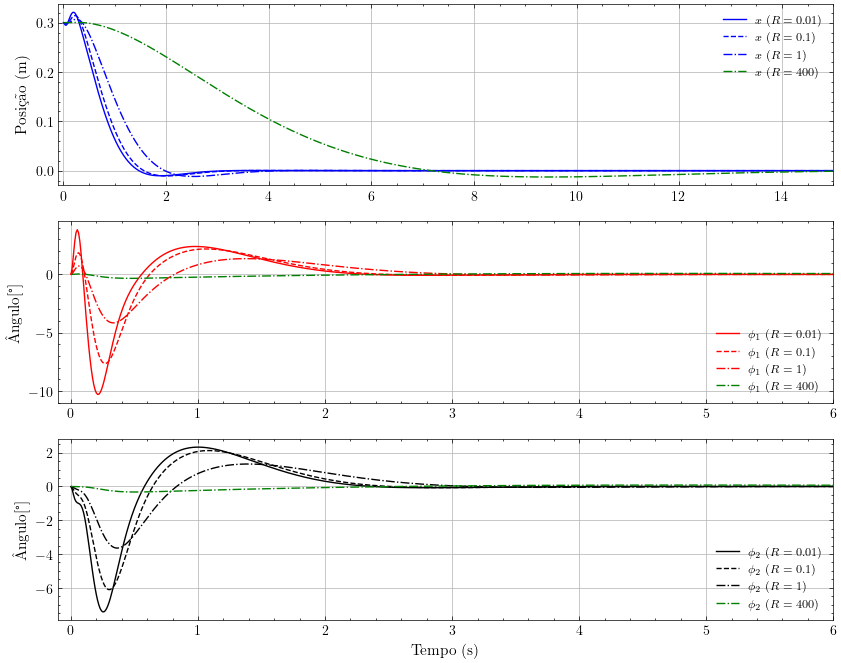

In [521]:
# Plotando sinais de Regulação
plt.figure(figsize=(10,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)
plt.plot(t,xsr_1.T[0],'-b',linewidth=1,label='$x$ ($R=0.01$)')
plt.plot(t,xsr_2.T[0],'--b',linewidth=1,label='$x$ ($R=0.1$)')
plt.plot(t,xsr_3.T[0],'-.b',linewidth=1,label='$x$ ($R=1$)')
plt.plot(t,xsr_4.T[0],'-.g',linewidth=1,label='$x$ ($R=400$)')
plt.xlim([-0.1, 15])
plt.ylabel('Posição (m)',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t,xsr_1.T[1]*180/np.pi,'-r',linewidth=1,label='$\\phi_1$ ($R=0.01$)')
plt.plot(t,xsr_2.T[1]*180/np.pi,'--r',linewidth=1,label='$\\phi_1$ ($R=0.1$)')
plt.plot(t,xsr_3.T[1]*180/np.pi,'-.r',linewidth=1,label='$\\phi_1$ ($R=1$)')
plt.plot(t,xsr_4.T[1]*180/np.pi,'-.g',linewidth=1,label='$\\phi_1$ ($R=400$)')
plt.xlim([-0.1, 6])
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t,xsr_1.T[2]*180/np.pi,'-k',linewidth=1,label='$\\phi_2$ ($R=0.01$)')
plt.plot(t,xsr_2.T[2]*180/np.pi,'--k',linewidth=1,label='$\\phi_2$ ($R=0.1$)')
plt.plot(t,xsr_3.T[2]*180/np.pi,'-.k',linewidth=1,label='$\\phi_2$ ($R=1$)')
plt.plot(t,xsr_4.T[2]*180/np.pi,'-.g',linewidth=1,label='$\\phi_2$ ($R=400$)')
plt.xlim([-0.1, 6])
plt.xlabel('Tempo (s)',fontsize=11)
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.savefig('Cap4_lqr_NL_caso2_sys_mf.png', dpi=400,bbox_inches='tight')
plt.show()

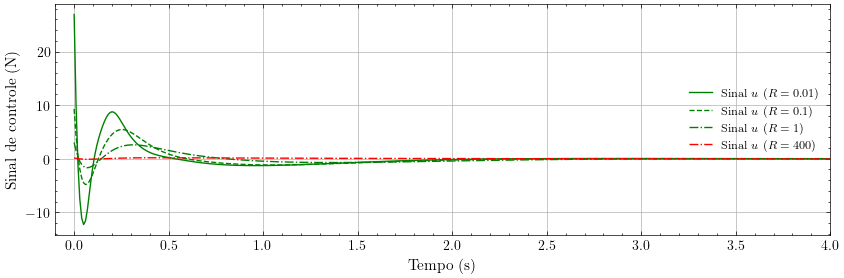

In [514]:
# Sinal de controle - Regulação
plt.figure(figsize=(10,3))
plt.plot(t, u_lqr_historico_reg_1_nl ,'-g', label = 'Sinal $u$ ($R=0.01$)')
plt.plot(t, u_lqr_historico_reg_2_nl ,'--g', label = 'Sinal $u$ ($R=0.1$)')
plt.plot(t, u_lqr_historico_reg_3_nl ,'-.g', label = 'Sinal $u$ ($R=1$)')
plt.plot(t, u_lqr_historico_reg_4_nl ,'-.r', label = 'Sinal $u$ ($R=400$)')
#plt.plot(t_dmf_1_t, sinal_de_controle_d1_t,':r', label = '$Sinal\\;de\\;controle$ $(u)$')
#plt.plot(t_dmf_4_t, sinal_de_controle_d4_t,'-.b', label = '$Sinal\\;de\\;controle$ $(u)$')
plt.xlim([-0.1, 4])
plt.ylabel('Sinal de controle (N)',fontsize=11, color='k')
plt.xlabel('Tempo (s)',fontsize=11)
plt.legend(loc='center right',fontsize='small')
plt.grid(True)

plt.savefig('Cap4_lqr_NL_caso_3_sinaisU_sys_mf.png', dpi=400,bbox_inches='tight')
plt.show()

In [499]:
np.max(u_lqr_historico_reg_4_nl)

0.18416024590685137

In [500]:
np.min(u_lqr_historico_reg_4_nl)

-0.08763695966317257

In [522]:
# Defina o vetor de estado de referência (xr).
# Assumindo que o primeiro estado deve seguir o degrau unitário (valor 1.0)
# e os demais estados devem permanecer em 0.
xr = np.array([
    1.0,  # Referência para o estado xs_[0]
    0.0,  # Referência para o estado xs_[1]
    0.0,  # Referência para o estado xs_[2]
    0.0,  # Referência para o estado xs_[3]
    0.0,  # Referência para o estado xs_[4]
    0.0   # Referência para o estado xs_[5]
])

In [523]:
# Dinâmica não linear do sistema com tracking de referência
def nlodek_com_referencia(es_, t, K, Anl, Bnl, xi):
    """
    Função da dinâmica não linear para LQR tracking.

    Argumentos:
    xs_ -- Vetor de estado atual
    t   -- Tempo atual
    K   -- Matriz de ganhos do LQR
    Anl -- Matriz A simbólica (ex: SymPy)
    Bnl -- Matriz B simbólica (ex: SymPy)
    xr  -- Vetor de estado de referência
    """
    # Esta parte, que calcula as matrizes A e B para o estado atual, permanece a mesma
    A_nlode = np.array(Anl.subs({x: es_[0], phi1: es_[1], phi2: es_[2], x_d: es_[3], phi1_d: es_[4], phi2_d: es_[5]})).astype(np.float64)
    B_nlode = np.array(Bnl.subs({x: es_[0], phi1: es_[1], phi2: es_[2], x_d: es_[3], phi1_d: es_[4], phi2_d: es_[5]})).astype(np.float64)

    # --- ALTERAÇÃO PRINCIPAL ---
    # 1. Calcular o erro entre o estado atual e a referência
    erro = es_ - xr

    # 2. Calcular a ação de controle baseada no erro (Lei de controle para TRACKING)
    u_lqr = -K @ erro

    # A equação de estados (x_ponto = A*x + B*u) permanece a mesma, mas agora 'u' leva a referência em conta.
    # Usamos u_lqr[0] ou u_lqr.item() se u_lqr for uma matriz 1x1, para garantir a multiplicação correta
    dxrdtr = np.dot(A_nlode, es_) + np.dot(B_nlode, u_lqr)
    return dxrdtr.flatten()

In [538]:
#Condições iniciais (as mesmas da sua imagem)
# Nota: a condição inicial para o primeiro estado já é 1.0, o mesmo valor
# da referência. O controlador atuará para levar os outros 5 estados a zero.
#x0 = [0.8, np.deg2rad(5), np.deg2rad(5), 0, 0, 0] # OK#
#x0 = [0.8, np.deg2rad(0), np.deg2rad(0), 0, 0, 0] # OK#
#x0 = [0.7, np.deg2rad(5), np.deg2rad(5), 0, 0, 0] # OK#
#x0 = [0.5, np.deg2rad(5), np.deg2rad(5), 0, 0, 0] # OK#
#x0 = [0.3, np.deg2rad(5), np.deg2rad(5), 0, 0, 0] # OK###########
#x0 = [0.2, np.deg2rad(5), np.deg2rad(5), 0, 0, 0] # OK#
x0 = [0.5, np.deg2rad(5), np.deg2rad(0), 0, 0, 0] # OK###########
# Vetor de tempo
#t = np.linspace(0, 15, 500) # Exemplo de vetor de tempo  # Exemplo de vetor de tempo
t = np.arange(0, 15, Ts) 
# --- ALTERAÇÃO NA CHAMADA ODEINT ---
# Adicione 'xr' ao final da tupla 'args'
xs_t1 = odeint(nlodek_com_referencia, x0, t, args=(Kd1, Anl_1, Bnl_2, xr))
xs_t2 = odeint(nlodek_com_referencia, x0, t, args=(Kd2, Anl_1, Bnl_2, xr))
xs_t3 = odeint(nlodek_com_referencia, x0, t, args=(Kd3, Anl_1, Bnl_2, xr))
xs_t4 = odeint(nlodek_com_referencia, x0, t, args=(Kd4, Anl_1, Bnl_2, xr))

u_lqr_tracking_caso1 = -(Kd1 @ xs_t1.T).flatten()
u_lqr_tracking_caso2 = -(Kd2 @ xs_t2.T).flatten()
u_lqr_tracking_caso3 = -(Kd3 @ xs_t3.T).flatten()
u_lqr_tracking_caso4 = -(Kd4 @ xs_t4.T).flatten()

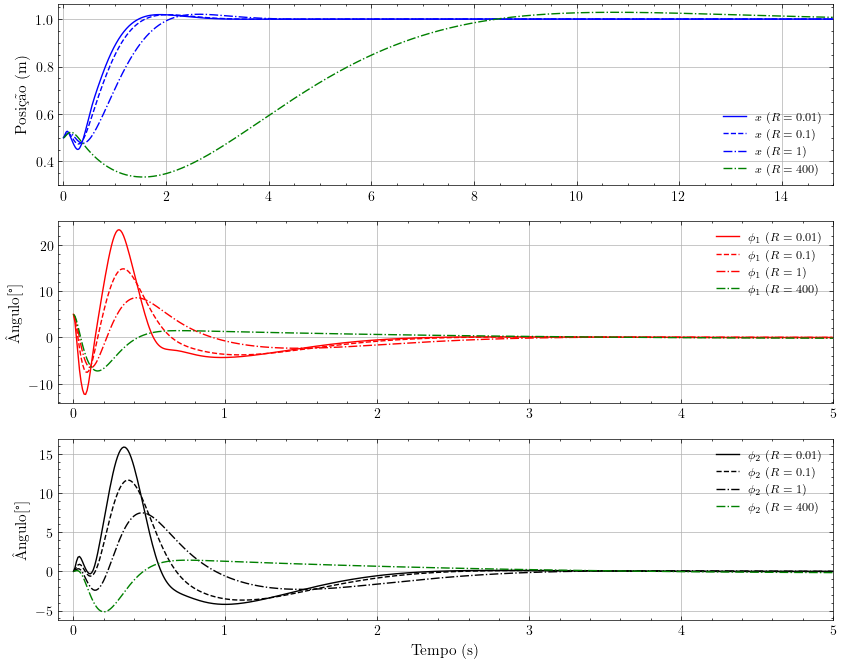

In [540]:
# Plotando sinais de Tracking
plt.figure(figsize=(10,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)
plt.plot(t,xs_t1.T[0],'-b',linewidth=1,label='$x$ ($R=0.01$)')
plt.plot(t,xs_t2.T[0],'--b',linewidth=1,label='$x$ ($R=0.1$)')
plt.plot(t,xs_t3.T[0],'-.b',linewidth=1,label='$x$ ($R=1$)')
plt.plot(t,xs_t4.T[0],'-.g',linewidth=1,label='$x$ ($R=400$)')
plt.xlim([-0.1, 15])
plt.ylabel('Posição (m)',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t,xs_t1.T[1]*180/np.pi,'-r',linewidth=1,label='$\\phi_1$ ($R=0.01$)')
plt.plot(t,xs_t2.T[1]*180/np.pi,'--r',linewidth=1,label='$\\phi_1$ ($R=0.1$)')
plt.plot(t,xs_t3.T[1]*180/np.pi,'-.r',linewidth=1,label='$\\phi_1$ ($R=1$)')
plt.plot(t,xs_t4.T[1]*180/np.pi,'-.g',linewidth=1,label='$\\phi_1$ ($R=400$)')
plt.xlim([-0.1, 5])
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t,xs_t1.T[2]*180/np.pi,'-k',linewidth=1,label='$\\phi_2$ ($R=0.01$)')
plt.plot(t,xs_t2.T[2]*180/np.pi,'--k',linewidth=1,label='$\\phi_2$ ($R=0.1$)')
plt.plot(t,xs_t3.T[2]*180/np.pi,'-.k',linewidth=1,label='$\\phi_2$ ($R=1$)')
plt.plot(t,xs_t4.T[2]*180/np.pi,'-.g',linewidth=1,label='$\\phi_2$ ($R=400$)')
plt.xlim([-0.1, 5])
plt.xlabel('Tempo (s)',fontsize=11)
plt.ylabel('Ângulo[°]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.savefig('Cap4_lqr_NL_AI_caso_5_sys_mf.png', dpi=400,bbox_inches='tight')
plt.show()

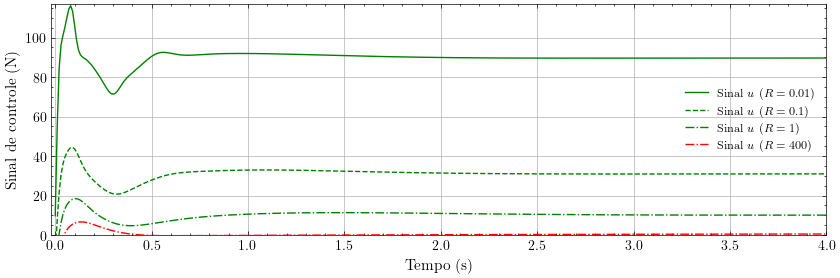

In [543]:
# Sinal de controle - Ação integralwww
plt.figure(figsize=(10,3))
plt.plot(t, u_lqr_tracking_caso1 ,'-g', label = 'Sinal $u$ ($R=0.01$)')
plt.plot(t, u_lqr_tracking_caso2 ,'--g', label = 'Sinal $u$ ($R=0.1$)')
plt.plot(t, u_lqr_tracking_caso3 ,'-.g', label = 'Sinal $u$ ($R=1$)')
plt.plot(t, u_lqr_tracking_caso4 ,'-.r', label = 'Sinal $u$ ($R=400$)')
plt.ylim([0,117])
plt.xlim([-0.02,4])
plt.ylabel('Sinal de controle (N)',fontsize=11, color='k')
plt.xlabel('Tempo (s)',fontsize=11)
plt.legend(loc='center right',fontsize='small')
plt.grid(True)

plt.savefig('Cap4_lqr_NL_AI_caso_5_sinaisU_sys_mf.png', dpi=400,bbox_inches='tight')
plt.show()

In [544]:
np.mean(u_lqr_tracking_caso1)

89.65258232278485

## Comparação - Linear x Não Linear



Dinâmica Linear

In [ ]:
"""# Matriz H de Massas do sistema:
H = sym.Matrix((sym.diff(eq_x,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd))).subs(ponto_eq)

# Matriz H inversa
H_inv = H.inv()
H"""

'# Matriz H de Massas do sistema:\nH = sym.Matrix((sym.diff(eq_x,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd))).subs(ponto_eq)\n\n# Matriz H inversa\nH_inv = H.inv()\nH'

In [ ]:
"""# Matriz de efeito corolis e atritos viscosos
N = sym.Matrix((sym.diff(eq_x,q_d),sym.diff(eqn_phi1,q_d),sym.diff(eqn_phi2,q_d))).subs(ponto_eq)
N"""

'# Matriz de efeito corolis e atritos viscosos\nN = sym.Matrix((sym.diff(eq_x,q_d),sym.diff(eqn_phi1,q_d),sym.diff(eqn_phi2,q_d))).subs(ponto_eq)\nN'

In [ ]:
"""# Matriz dos efeitos das massas e da gravidade
W = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)]).subs({sym.sin(phi1): phi1,sym.sin(phi2): phi2})
W"""

'# Matriz dos efeitos das massas e da gravidade\nW = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)]).subs({sym.sin(phi1): phi1,sym.sin(phi2): phi2})\nW'

In [ ]:
"""# Matriz de entradas

V = sym.Matrix([u_l,0,0])
V"""

'# Matriz de entradas\n\nV = sym.Matrix([u_l,0,0])\nV'

In [ ]:
"""N*q_d.transpose()"""

'N*q_d.transpose()'

In [ ]:
"""# Multiplicação matricial

C = N*q_d.transpose() + W # C+W

S = (H_inv*C)#.subs(ponto_eq)
S"""

'# Multiplicação matricial\n\nC = N*q_d.transpose() + W # C+W\n\nS = (H_inv*C)#.subs(ponto_eq)\nS'

In [ ]:
"""q_dd"""

'q_dd'

In [ ]:
"""# Criando a Matriz de estados A
A_0 = sym.Matrix([q_dd.transpose(),S])
A_1 = A_0.jacobian(q_ef)
A_1"""

'# Criando a Matriz de estados A\nA_0 = sym.Matrix([q_dd.transpose(),S])\nA_1 = A_0.jacobian(q_ef)\nA_1'

In [ ]:
""""# Criando a Matriz de estados B
B_0 = sym.Matrix([q_dd.transpose(),H_inv*V])
B_1 = B_0.jacobian([u_l])
B_1"""

'"# Criando a Matriz de estados B\nB_0 = sym.Matrix([q_dd.transpose(),H_inv*V])\nB_1 = B_0.jacobian([u_l])\nB_1'

In [ ]:
"""# Retorna as variveis para simbolo novamente:
M, m1, m2, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 l1 l2 J1 J2 g t  f0 f1 f2')"""

"# Retorna as variveis para simbolo novamente:\nM, m1, m2, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 l1 l2 J1 J2 g t  f0 f1 f2')"

In [ ]:
"""# Valor dos parâmetros do sistema:
valor_param_dGisele = {M:1,m1:1,m2:1,J1:0.00083,J2:0.00083,\
               l1:0.05,l2:0.05,g:9.81,f0:0.01,f1:0.007,f2:0.007}"""


'# Valor dos parâmetros do sistema:\nvalor_param_dGisele = {M:1,m1:1,m2:1,J1:0.00083,J2:0.00083,               l1:0.05,l2:0.05,g:9.81,f0:0.01,f1:0.007,f2:0.007}'

In [ ]:
"""# Matriz A - Substituindo os parâmetros
A_s = A_1.subs(valor_param_dGisele)
A = np.matrix(A_s).astype(np.float64)
A"""

'# Matriz A - Substituindo os parâmetros\nA_s = A_1.subs(valor_param_dGisele)\nA = np.matrix(A_s).astype(np.float64)\nA'

In [ ]:
"""# Matriz B
B_s = B_1.subs(valor_param_dGisele)
B = np.matrix(B_s).astype(np.float64)
B"""

'# Matriz B\nB_s = B_1.subs(valor_param_dGisele)\nB = np.matrix(B_s).astype(np.float64)\nB'

In [ ]:
"""# Matriz C
C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

# Matriz D
D = np.zeros((3,1))"""

'# Matriz C\nC = np.array([[1, 0, 0, 0, 0, 0],\n              [0, 1, 0, 0, 0, 0],\n              [0, 0, 1, 0, 0, 0]])\n\n# Matriz D\nD = np.zeros((3,1))'

In [ ]:
"""s_lin_ma = ct.ss(A,B,C,D)
s_lin_ma"""

's_lin_ma = ct.ss(A,B,C,D)\ns_lin_ma'

In [ ]:
"""# Polos do sistema
polos = ct.poles(s_lin_ma)
zeros_s = ct.zeros(s_lin_ma)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)"""

"# Polos do sistema\npolos = ct.poles(s_lin_ma)\nzeros_s = ct.zeros(s_lin_ma)\nprint('Os polos do sistema são: ', polos     , 'Os zeros do sistema são: ',zeros_s)"

# 2 Dinâmica Linear


In [ ]:
"""# Polos do sistema
polos = ct.poles(sys_d_ma)
zeros_s = ct.zeros(sys_d_ma)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)"""

"# Polos do sistema\npolos = ct.poles(sys_d_ma)\nzeros_s = ct.zeros(sys_d_ma)\nprint('Os polos do sistema são: ', polos     , 'Os zeros do sistema são: ',zeros_s)"

In [ ]:
"""# Pólos do sistema ma discreto
plt.figure(figsize=(12, 12)) 
ct.pzmap(s_lin_ma,grid=True, color='r',marker_size=6.4)"""

"# Pólos do sistema ma discreto\nplt.figure(figsize=(12, 12)) \nct.pzmap(s_lin_ma,grid=True, color='r',marker_size=6.4)"

In [ ]:
"""# Pólos do sistema ma discreto
plt.figure(figsize=(12, 12)) 
ct.pzmap(sys_c_ma,grid=True, color='r',marker_size=6.4)"""

"# Pólos do sistema ma discreto\nplt.figure(figsize=(12, 12)) \nct.pzmap(sys_c_ma,grid=True, color='r',marker_size=6.4)"

In [ ]:
"""# Pólos do sistema ma discreto

plt.figure(figsize=(6, 6)) 
ct.pzmap(sys_d_ma,plot=True,title ='Polos do sistema',grid=True,color='r',marker_size=6.4,xlim=[0.5,1.2],ylim=[-0.3,0.3],scaling=True)"""


"# Pólos do sistema ma discreto\n\nplt.figure(figsize=(6, 6)) \nct.pzmap(sys_d_ma,plot=True,title ='Polos do sistema',grid=True,color='r',marker_size=6.4,xlim=[0.5,1.2],ylim=[-0.3,0.3],scaling=True)"

In [ ]:
"""# Plotar resposta inicial do sistema

x0 = np.array([[0.0],[0.0],[0.1],[0],[0],[0]])
tp = np.arange(0, 3, Ts) 
#t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial
t,y = ct.initial_response(sys_discreto, tp,x0) # Resposta Inicial
r,d = ct.step_response(sys,tp,x0) # Resposta ao degrau"""

'# Plotar resposta inicial do sistema\n\nx0 = np.array([[0.0],[0.0],[0.1],[0],[0],[0]])\ntp = np.arange(0, 3, Ts) \n#t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial\nt,y = ct.initial_response(sys_discreto, tp,x0) # Resposta Inicial\nr,d = ct.step_response(sys,tp,x0) # Resposta ao degrau'

In [ ]:
"""altura = 4
largura = 9

plt.style.use(['seaborn-v0_8-ticks'])
#plt.style.use(['science','seaborn-v0_8-whitegrid'])
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0], '-r',label='Posicao do carro [m]')
subplots[1].plot(t,y[1], '-g',label=r'$\hat{A}$ngulo do pendulo inferior [rad]')
subplots[1].plot(t,y[2], label=r'$\hat{A}$ngulo do pendulo superior[rad]')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()"""



<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
C:\Users\mateu\AppData\Local\Temp\ipykernel_8068\38828048.py:1: SyntaxWarning: invalid escape sequence '\h'
  """altura = 4


"altura = 4\nlargura = 9\n\nplt.style.use(['seaborn-v0_8-ticks'])\n#plt.style.use(['science','seaborn-v0_8-whitegrid'])\nsubplots = plt.subplots(1, 1, figsize=(largura, altura))\nsubplots[1].plot(t,y[0], '-r',label='Posicao do carro [m]')\nsubplots[1].plot(t,y[1], '-g',label=r'$\\hat{A}$ngulo do pendulo inferior [rad]')\nsubplots[1].plot(t,y[2], label=r'$\\hat{A}$ngulo do pendulo superior[rad]')\nsubplots[1].set_title('Resposta Inicial')\nsubplots[1].set_xlabel('Tempo (s)')\nsubplots[1].set_ylabel('Posicao (m)')\nsubplots[1].grid(True)\nsubplots[1].legend()\nplt.show()"

In [ ]:
"""altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
#subplots[1].plot(t,d[0][0], label='x')
subplots[1].plot(t,d[1][0], label='angulo phi1')
subplots[1].plot(t,d[2][0], label='angulo phi2')
subplots[1].set_title('Resposta ao Degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição [rad]')
subplots[1].grid(True)
subplots[1].legend()
plt.show()"""

"altura = 4\nlargura = 9\nsubplots = plt.subplots(1, 1, figsize=(largura, altura))\n#subplots[1].plot(t,d[0][0], label='x')\nsubplots[1].plot(t,d[1][0], label='angulo phi1')\nsubplots[1].plot(t,d[2][0], label='angulo phi2')\nsubplots[1].set_title('Resposta ao Degrau')\nsubplots[1].set_xlabel('Tempo (s)')\nsubplots[1].set_ylabel('Posição [rad]')\nsubplots[1].grid(True)\nsubplots[1].legend()\nplt.show()"